In [11]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/emails-for-spam-or-ham-classification-trec-2006/email_origin.csv
/kaggle/input/emails-for-spam-or-ham-classification-trec-2006/email_text.csv
/kaggle/input/emails-for-spam-or-ham-classification-trec-2006/trec06p.tgz


In [12]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 6.9 MB/s eta 0:00:00:00:01


In [13]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gc

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer
from sentence_transformers import SentenceTransformer

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import StepLR

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

!unzip -n /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Loading data

In [14]:
df = pd.read_csv(
    '/kaggle/input/emails-for-spam-or-ham-classification-trec-2006/email_text.csv',
    nrows=1000
)

print('Shape:', df.shape)
df.head()

Shape: (1000, 2)


,label,text
0,0,the mailing list i queried about a few weeks a...
1,1,luxury watches buy your own rolex for only esc...
2,1,academic qualifications available from prestig...
3,0,greetings all this is to verify your subscript...
4,1,try chauncey may conferred the luscious not co...


In [15]:
df.isna().sum()

label    0
text     0
dtype: int64

In [16]:
df = df.dropna()
df.shape

(1000, 2)

## Preprocessing

In [17]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text):
    text = text.lower()
    
    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

In [18]:
df['cleaned_text'] = df['text'].map(
    lambda comments: text_cleaner(comments)
)

In [19]:
print("Распределение классов:")
df['label'].value_counts()*100/df.shape[0]

Распределение классов:


label
0    65.2
1    34.8
Name: count, dtype: float64

## Modeling

In [20]:
class SpamClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.9):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [21]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    accuracy_history = list()
    f1_history = list()

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float()).squeeze()
            preds = (outputs > 0.5).float()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            accuracy_history.append(accuracy_score(labels, preds))
            f1_history.append(f1_score(labels, preds))

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.float()).squeeze()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    return accuracy, f1, accuracy_history, f1_history

## Embeddings BERT

In [22]:
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [23]:
bert_tokens = bert_tokenizer(df['cleaned_text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=128)
gc.collect()

0

In [24]:
bert_tokens['input_ids'].shape

torch.Size([1000, 128])

In [25]:
batch_size = 150
n_batches = math.ceil(bert_tokens['input_ids'].shape[0]/batch_size)
print(f'{n_batches=}, {batch_size=}')

bert_embeddings_batches = []

for n_batch in range(n_batches):
    bert_embeddings_part = bert_model(**{k: bert_tokens[k][
                                             n_batch*batch_size:(n_batch+1)*batch_size
                                         ]
                                         for k in bert_tokens.keys()
                                     })

    bert_embeddings_batches.append(bert_embeddings_part.last_hidden_state.mean(dim=1).detach().numpy())
    del(bert_embeddings_part)
    gc.collect()

bert_embeddings = np.vstack(bert_embeddings_batches)
del(bert_embeddings_batches)
gc.collect()
bert_embeddings.shape

n_batches=7, batch_size=150


(1000, 768)

In [26]:
bert_X_train, bert_X_test, bert_y_train, bert_y_test = train_test_split(
    bert_embeddings, df['label'].values, test_size=0.2, random_state=42
)

gc.collect()
bert_X_train.shape, bert_X_test.shape, bert_y_train.shape, bert_y_test.shape

((800, 768), (200, 768), (800,), (200,))

## Modeling BERT

In [27]:
input_size = bert_embeddings.shape[1]
hidden_size = 256
output_size = 1

model = SpamClassifier(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [28]:
bert_scores = dict()
bert_scores['acc'], bert_scores['f1'], bert_scores['acc_hist'], bert_scores['f1_hist'] = (
    train_and_evaluate(model, bert_X_train, bert_X_test, bert_y_train, bert_y_test)
)
print('Acc:', bert_scores['acc'])
print('F1:', bert_scores['f1'])

Acc: 0.955
F1: 0.9243697478991596


## Embeddings GPT2

In [29]:
gpt2_model_name = 'gpt2'
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

gpt2_model = GPT2Model.from_pretrained('gpt2')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [30]:
gpt2_tokens = gpt2_tokenizer(df['cleaned_text'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=128)
gc.collect()

17

In [31]:
gpt2_tokens['input_ids'].shape

torch.Size([1000, 128])

In [32]:
batch_size = 150
n_batches = math.ceil(gpt2_tokens['input_ids'].shape[0]/batch_size)
print(f'{n_batches=}, {batch_size=}')

gpt2_embeddings_batches = []

for n_batch in range(n_batches):
    gpt2_embeddings_part = gpt2_model(**{k: gpt2_tokens[k][
                                             n_batch*batch_size:(n_batch+1)*batch_size
                                         ]
                                         for k in gpt2_tokens.keys()
                                     })

    gpt2_embeddings_batches.append(gpt2_embeddings_part.last_hidden_state.mean(dim=1).detach().numpy())
    del(gpt2_embeddings_part)
    gc.collect()

gpt2_embeddings = np.vstack(gpt2_embeddings_batches)
del(gpt2_embeddings_batches)
gc.collect()
gpt2_embeddings.shape

n_batches=7, batch_size=150


(1000, 768)

In [33]:
gpt2_X_train, gpt2_X_test, gpt2_y_train, gpt2_y_test = train_test_split(
    gpt2_embeddings, df['label'].values, test_size=0.2, random_state=42
)

gc.collect()
gpt2_X_train.shape, gpt2_X_test.shape, gpt2_y_train.shape, gpt2_y_test.shape

((800, 768), (200, 768), (800,), (200,))

## Modeling GPT2

In [34]:
input_size = gpt2_embeddings.shape[1]
hidden_size = 256
output_size = 1

model = SpamClassifier(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [35]:
gpt2_scores = dict()
gpt2_scores['acc'], gpt2_scores['f1'], gpt2_scores['acc_hist'], gpt2_scores['f1_hist'] = (
    train_and_evaluate(model, gpt2_X_train, gpt2_X_test, gpt2_y_train, gpt2_y_test)
)
print('Acc:', gpt2_scores['acc'])
print('F1:', gpt2_scores['f1'])

Acc: 0.895
F1: 0.829268292682927


## Visualization

In [36]:
# gpt2_scores

In [38]:
len(gpt2_scores['acc_hist'])

250

In [39]:
len(bert_scores['acc_hist'])

250

In [ ]:
len(range(len(gpt2_scores['acc_hist']))

In [53]:
history = pd.DataFrame({
    'gpt2_acc_hist': gpt2_scores['acc_hist'],
    'gpt2_f1_hist': gpt2_scores['f1_hist'],
    'bert_acc_hist': bert_scores['acc_hist'],
    'bert_f1_hist': bert_scores['f1_hist'],
})

history.head()

,gpt2_acc_hist,gpt2_f1_hist,bert_acc_hist,bert_f1_hist
0,0.46875,0.190476,0.50000,0.333333
1,0.50000,0.272727,0.53125,0.210526
2,0.37500,0.333333,0.68750,0.285714
3,0.59375,0.480000,0.62500,0.250000
4,0.53125,0.285714,0.68750,0.166667


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

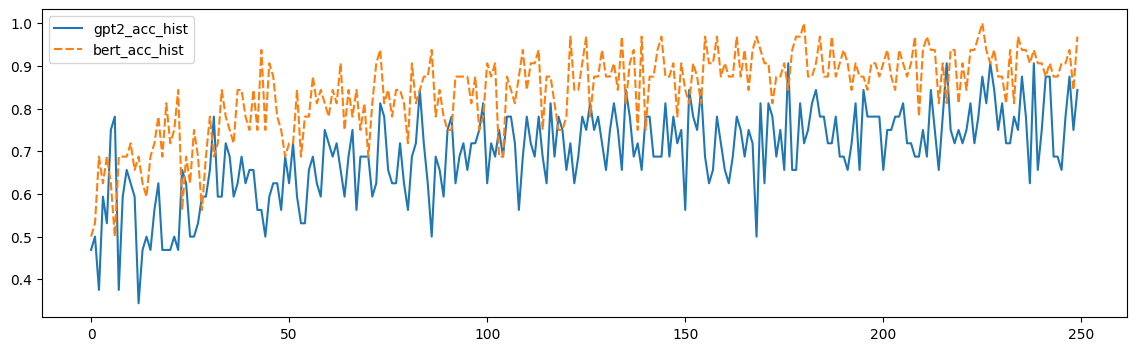

In [65]:
f, ax = plt.subplots(figsize=(14, 4))

sns.lineplot(
    history[['gpt2_acc_hist', 'bert_acc_hist']],
    ax=ax
)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

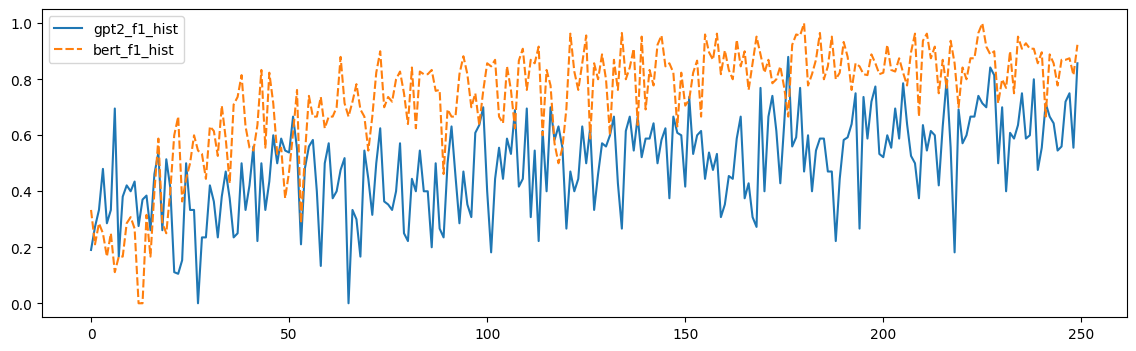

In [66]:
f, ax = plt.subplots(figsize=(14, 4))

sns.lineplot(
    history[['gpt2_f1_hist', 'bert_f1_hist']],
    ax=ax
)